## Metaverse Transaction Data Analysis

### Script Goals
- Explore Meta Transaction Data and build machine learning models to classify categorical risk level.
- Contrast HalvingGridSearch and Bayesian Optimization with cross-validated scores. 
    - Accuracy
    - Time to complete hyperparameter search
- Using scikit-learn, create model pipeline to test different model types.
- Combine models into voting and stacking ensemble models.

Test Voting and Stacking Ensemble methods

### Data Dictionary
https://www.kaggle.com/datasets/faizaniftikharjanjua/metaverse-financial-transactions-dataset

The dataset includes 78,600 records, each representing a metaverse transaction with the following attributes:

- **Timestamp:** Date and time of the transaction.
- **Hour of Day:** Hour part of the transaction timestamp.
- **Sending Address:** Blockchain address of the sender.
- **Receiving Address:** Blockchain address of the receiver.
- **Amount:** Transaction amount in a simulated currency.
- **Transaction Type:** Categorization of the transaction (e.g., transfer, sale, purchase, scam, phishing).
- **Location Region:** Simulated geographical region of the transaction.
- **IP Prefix:** Simulated IP address prefix for the transaction.
- **Login Frequency:** Frequency of login sessions by the user, varying by age group.
-  **Session Duration:** Duration of activity sessions in minutes.
- **Purchase Pattern:** Behavioral pattern of purchases (e.g., focused, random, high-value).
- **Age Group:** Categorization of users into new, established, and veteran based on their activity history.
- **Risk Score:** Calculated risk score based on transaction characteristics and user behavior.
- **Anomaly:** Risk level assessment (e.g., high_risk, moderate_risk, low_risk)

In [5]:
### Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
import skopt
import lightgbm as lgb
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from skopt.space import Real, Categorical, Integer
from lightgbm import LGBMClassifier

### Other Options
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [10,5]

# Multiple Outputs Per Code Block 
%config InteractiveShell.ast_node_interactivity = 'all'


In [3]:
# Read in Data
meta = pd.read_csv('C:/Users/WulfN/datasets/metaverse_transactions_dataset.csv') # 'C:/Your/File/Path'

meta['timestamp'] = pd.to_datetime(meta['timestamp'])
meta = (meta.sort_values('timestamp') 
            .reset_index()
            .drop('index', axis = 1)
            )

meta.info()
meta.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78600 entries, 0 to 78599
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   timestamp          78600 non-null  datetime64[ns]
 1   hour_of_day        78600 non-null  int64         
 2   sending_address    78600 non-null  object        
 3   receiving_address  78600 non-null  object        
 4   amount             78600 non-null  float64       
 5   transaction_type   78600 non-null  object        
 6   location_region    78600 non-null  object        
 7   ip_prefix          78600 non-null  float64       
 8   login_frequency    78600 non-null  int64         
 9   session_duration   78600 non-null  int64         
 10  purchase_pattern   78600 non-null  object        
 11  age_group          78600 non-null  object        
 12  risk_score         78600 non-null  float64       
 13  anomaly            78600 non-null  object        
dtypes: dat

,timestamp,hour_of_day,sending_address,receiving_address,amount,transaction_type,location_region,ip_prefix,login_frequency,session_duration,purchase_pattern,age_group,risk_score,anomaly
0,2022-01-01 00:00:45,0,0x5e539dac6637b38aaf015861ec2da850f1ae8377,0x16c9903f99897fa292f3273513da8cf6525d0b06,592.024530,transfer,South America,10.00,6,84,high_value,veteran,49.6125,low_risk
1,2022-01-01 00:12:24,0,0xaaf2483f28bf10330253f83f9e016e1b900ad78b,0xa90b541bd2dfef162b82073318ace3fcc57340d9,755.500717,transfer,North America,172.16,3,70,focused,established,25.3125,low_risk
2,2022-01-01 00:14:54,0,0xccbf5a9926606c77db8391185066a8ee3bc0a2af,0x4f3070a2a31388c4897667752bbfac56d6426bb0,247.716361,transfer,Asia,192.00,5,54,focused,established,20.2500,low_risk
3,2022-01-01 00:27:12,0,0xffa670245089044b1e355508a7843692a25a5e52,0xc78a13e93a188c445584e724a855aeb94f972dd5,422.789709,purchase,North America,172.16,4,62,focused,established,35.4375,low_risk
4,2022-01-01 00:36:27,0,0xd92a3fafc71c2c3cde19665c9f46ec67638e33a1,0x55c98683de5bef9456cc9b82a87f0d8e942c7d6e,353.949174,sale,South America,172.16,7,94,high_value,veteran,70.8750,moderate_risk


In [4]:
meta.describe()

,timestamp,hour_of_day,amount,ip_prefix,login_frequency,session_duration,risk_score
count,78600,78600.000000,78600.000000,78600.000000,78600.000000,78600.000000,78600.000000
mean,2022-07-02 15:42:18.166437888,11.532634,502.574903,147.644430,4.178702,69.684606,44.956722
min,2022-01-01 00:00:45,0.000000,0.010000,10.000000,1.000000,20.000000,15.000000
25%,2022-04-02 02:37:59.500000,6.000000,331.319966,172.000000,2.000000,35.000000,26.250000
50%,2022-07-02 17:46:33,12.000000,500.029500,172.160000,4.000000,60.000000,40.000000
75%,2022-10-02 09:00:14,18.000000,669.528311,192.000000,6.000000,100.000000,52.500000
max,2022-12-31 23:47:40,23.000000,1557.150905,192.168000,8.000000,159.000000,100.000000
std,NaN,6.935897,245.898146,69.388143,2.366038,40.524476,21.775365


- Data is from 2022-01-01 through 2022-12-31

### EDA

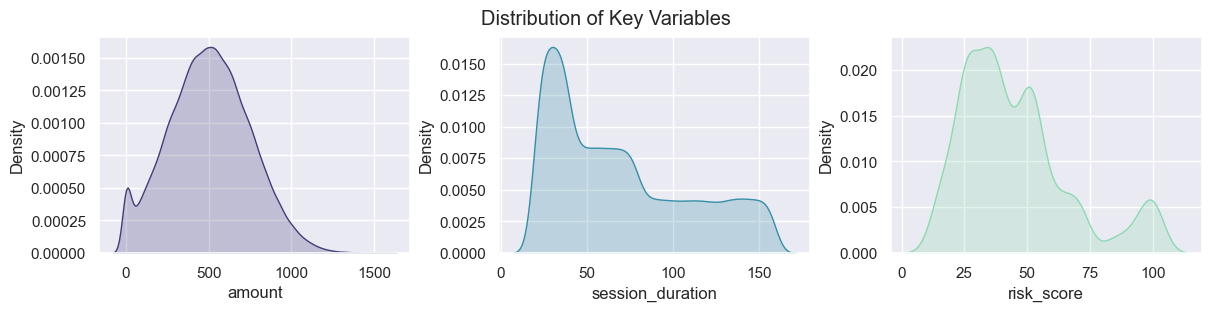

In [26]:
# Color Scheme
palette = sb.color_palette("mako")
hex_palette = palette.as_hex()[:]

# Distribution of Key Variables
fig, axs = plt.subplots(1, 3, figsize = (12,3), constrained_layout = True) 
sb.kdeplot(meta, x = 'amount', ax = axs[0], fill = True, color = hex_palette[1])
sb.kdeplot(meta, x = 'session_duration', ax = axs[1], fill = True, color = hex_palette[3])
sb.kdeplot(meta, x = 'risk_score', ax = axs[2], bw_adjust = 2, fill = True, color = hex_palette[5])

plt.suptitle('Distribution of Key Variables'); 

In [105]:
### Session duration dist by transaction type
count = pd.DataFrame(meta.groupby('transaction_type')['transaction_type'].value_counts(ascending = True))
count['perc'] = (count['count'] / count['count'].sum() * 100 ).round(2)

count

,count,perc
transaction_type,,
phishing,2546,3.24
purchase,24940,31.73
sale,25040,31.86
scam,3949,5.02
transfer,22125,28.15


- Despite purchases and sales, there are no negative transaction types. 
- Multiplying purchases by -1 so sales and purchases are differentiated (In feature engineering section).
- Low percentage of transaction types are 'scam' (5.02%) or 'phishing' (3.24%) type.

In [58]:
# What are the categories within the categorical variables?
unique_cats = {col: meta[col].unique() for col in ['transaction_type', 'purchase_pattern', 'age_group', 'anomaly', 'location_region']}
unique_cats = pd.DataFrame({'variables': unique_cats.keys(),
                            'categories': unique_cats.values()})
unique_cats

,variables,categories
0,transaction_type,"[transfer, purchase, sale, scam, phishing]"
1,purchase_pattern,"[high_value, focused, random]"
2,age_group,"[veteran, established, new]"
3,anomaly,"[low_risk, moderate_risk, high_risk]"
4,location_region,"[South America, North America, Asia, Africa, E..."


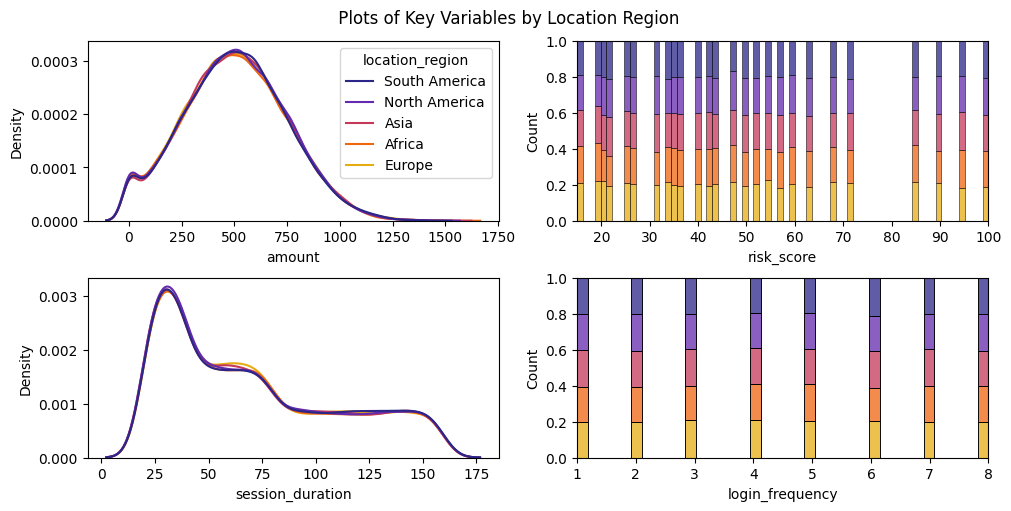

In [6]:
# Plots based on location region
sb.set_palette(palette = 'CMRmap')

fig, axs = plt.subplots(2, 2, constrained_layout = True)
sb.kdeplot(meta, x = 'amount', hue = 'location_region', ax = axs[0,0])
sb.histplot(meta, x = 'risk_score', hue = 'location_region', multiple = 'fill', ax = axs[0,1], legend = False)
sb.kdeplot(meta, x = 'session_duration', hue = 'location_region', ax = axs[1,0], legend = False)
sb.histplot(meta, x = 'login_frequency', hue = 'location_region', multiple = 'fill', ax = axs[1,1], legend = False)
plt.suptitle(' Plots of Key Variables by Location Region'); 
# plt.tight_layout()

Region has almost no impact on key variables. Omitting Region from the analysis

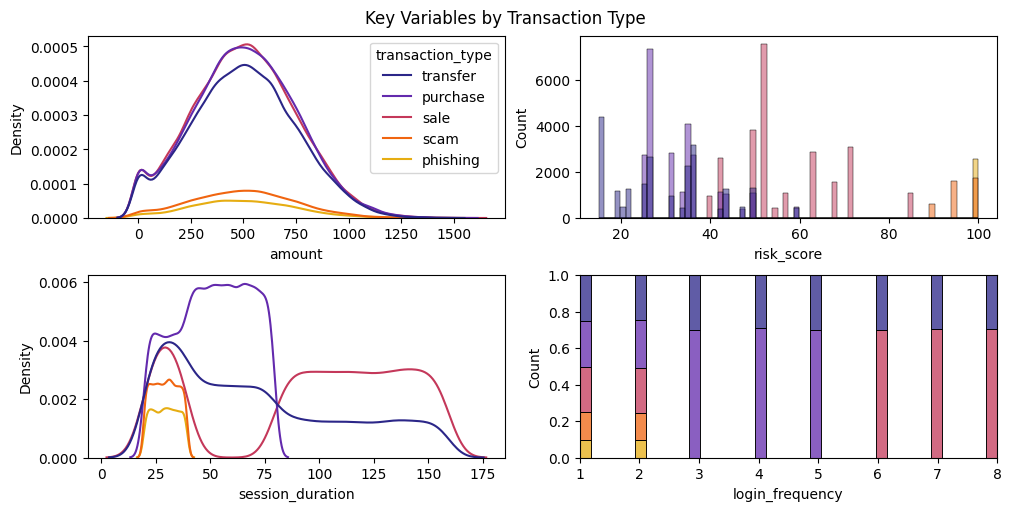

In [7]:
# Plots based on transaction type

fig, axs = plt.subplots(2, 2, constrained_layout = True)
sb.kdeplot(meta, x = 'amount', hue = 'transaction_type', ax = axs[0,0])
sb.histplot(meta, x = 'risk_score', hue = 'transaction_type', ax = axs[0,1], legend = False)
sb.kdeplot(meta, x = 'session_duration', hue = 'transaction_type', ax = axs[1,0], legend = False)
sb.histplot(meta, x = 'login_frequency', hue = 'transaction_type', multiple = 'fill', ax = axs[1,1], legend = False)
plt.suptitle('Key Variables by Transaction Type'); 

- Transaction type distributions have noticably different kurtosis.
    - Group 1: (transfer, purchase, sale)
    - Group 2: (scam, phishing)
- Phishing and scam transaction types have high risk scores. 
- Similarly, scam and phishing only exists under the following conditions: 
    - session_duration is less than 50
    - login frequency is less than 3. 
- Aside from transfers, only sales has login frequencies from 6 to 8. 
- **Are Scam / Phishing transaction types and the risk_score variables multicolinear with the target variable (anomaly)?**   


transaction_type count, risk score dist'n
Minimum risk_score for the high_risk anomalies:  90.0


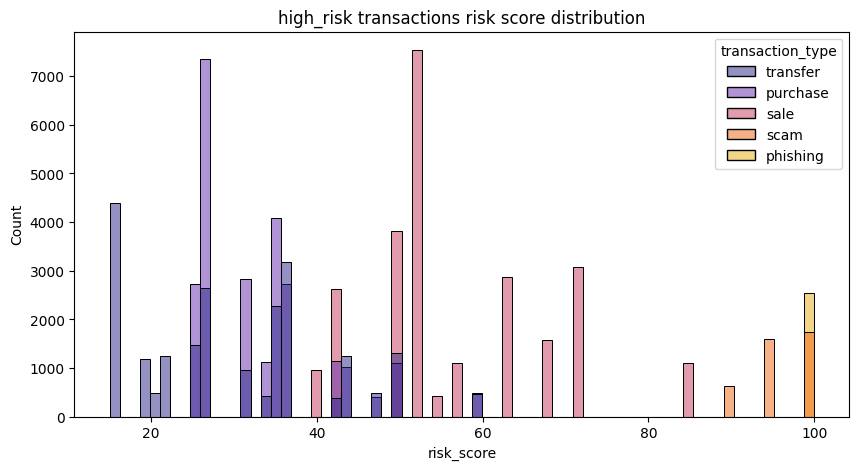

In [29]:
# Multicolinearity between target variable, scam / phishing transaction type, and risk_score?

meta_target_check = meta[['transaction_type', 'risk_score', 'anomaly']]
meta_target_check = meta_target_check[meta_target_check['anomaly' ] == 'high_risk']

print("transaction_type count, risk score dist'n")
meta_target_check['transaction_type'].value_counts()

print('Minimum risk_score for the high_risk anomalies: ', meta_target_check['risk_score'].min())

# high_risk transactions risk score distribution
sb.histplot(meta, x = 'risk_score', hue = 'transaction_type', legend = True); 
plt.title('high_risk transactions risk score distribution'); 

- All observations with risk_score > 90 are exclusively labeled scam or phishing
- All high risk anomolies are labeled scam/phishing transaction types.

### There is perfect multicollinearity with the anomaly target variable from the risk_score and transaction_type variables:
**Removing risk_score and transaction_type from future modeling.**
- This is done to build a model that can predict transaction risk WITHOUT needing to know if high risk variables are scam/phishing or have a high risk score.
- Models built on these variables would be useless on data where high risk transactions aren't known
- If scam / phishing is already known, then a model is not needed to predict classify these transactions


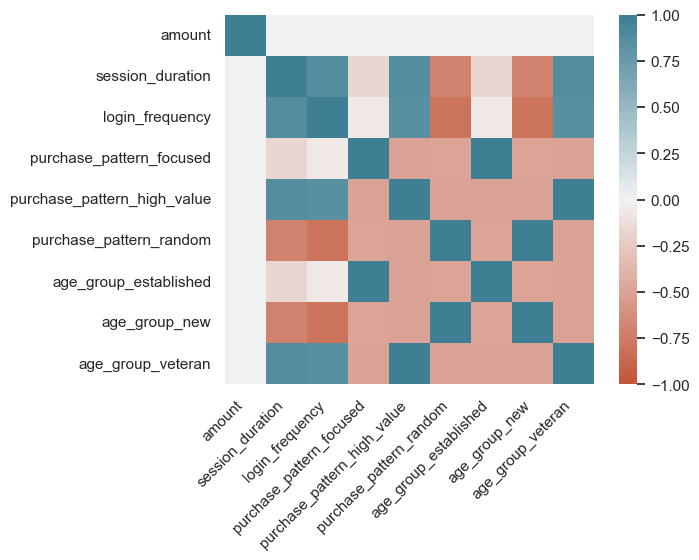

In [33]:
# Create indicator variables for purchase_pattern and age_group

# What is correlated?
indicator_vars = pd.get_dummies(meta[['purchase_pattern', 'age_group']], dtype = int)  # removing transaction type
indicator_vars.head()

corr = pd.concat([meta[['amount', 'session_duration', 'login_frequency']], indicator_vars], axis = 1).corr()

# creating correlation heatmap
ax = sb.heatmap(
    corr, 
    vmin = -1, vmax = 1, center = 0,
    cmap = sb.diverging_palette(20, 220, n=200),
    square = True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right'
); 


- Most variables have near 0 correlation the transaction amount. 
- Strong negative relationship exists between age group and purchase pattern indicators.
- 'Purchase pattern focused' and 'age group established' are negatively correlated with risk score and less like to be fraudulent.

In [103]:
### Preparing the following for day level stats
# 1. Sender and Receiver level variables: avg transaction amount, avg session duration, qty transactions
# 2. Hour level stats, Day of week level stats, Day level stats

sender_stats = (meta.groupby('sending_address')
                  .agg(sender_transaction_count = ('sending_address', 'count'))
                  .reset_index()
                )

receiver_stats = (meta.groupby('receiving_address')
                  .agg(receiver_transaction_count = ('receiving_address', 'count'))
                  .reset_index()
                  )

hour_level_stats = (meta.filter(['timestamp', 'hour_of_day', 'amount', 'session_duration', 'login_frequency'])
                   .groupby('hour_of_day')
                   .agg(hour_avg_amount = ('amount', 'mean'),
                        hour_avg_session_duration = ('session_duration', 'mean'),
                        hour_avg_login_frequency = ('login_frequency', 'mean'))
                   #.reset_index()
                   )                 

day_of_week_stats = (meta.assign(day_of_week = lambda x: x['timestamp'].dt.strftime('%a'))
                     .filter(['timestamp', 'day_of_week', 'amount', 'session_duration', 'login_frequency'])
                     .groupby('day_of_week')
                     .agg(day_avg_amount = ('amount', 'mean'),
                          day_avg_session_duration = ('session_duration', 'mean'),
                          day_avg_login_frequency = ('login_frequency', 'mean'))
                     #.reset_index()
                     )

day_stats = (meta.assign(month_day = lambda x: x['timestamp'].dt.strftime('%m-%d'))
             .filter(['timestamp', 'month_day', 'amount', 'session_duration', 'login_frequency'])
             .groupby('month_day')
             .agg(day_avg_amount = ('amount', 'mean'),
                  day_avg_session_duration = ('session_duration', 'mean'),
                  day_avg_login_frequency = ('login_frequency', 'mean'))
             #.reset_index()
             )

In [76]:
# sender_stats.head()
sender_stats.describe()
# receiver_stats.head()
receiver_stats.describe()

,sender_transaction_count
count,1161.000000
mean,67.700258
std,36.335692
min,29.000000
25%,29.000000
50%,58.000000
75%,87.000000
max,232.000000


,receiver_transaction_count
count,1166.000000
mean,67.409949
std,37.131665
min,29.000000
25%,29.000000
50%,58.000000
75%,87.000000
max,232.000000


- Large std for sender and reciever transaction counts
- Nearly identical sender / reciever transaction distributions

In [104]:
print('Hour Level Stats')
hour_level_stats.describe()
print('Day of Week Stats (Sun, Mon, ..., Sat)')
day_of_week_stats.describe()
print('Day Stats (Avg for Each Day of the Year)')
day_stats.describe()

Hour Level Stats


,hour_avg_amount,hour_avg_session_duration,hour_avg_login_frequency
count,24.000000,24.000000,24.000000
mean,502.560596,69.687725,4.178864
std,4.700523,0.723768,0.040243
min,493.081581,68.344595,4.113151
25%,499.566274,69.190535,4.156032
50%,502.137769,69.706868,4.177082
75%,505.429514,70.074039,4.213600
max,512.748696,70.898433,4.248332


Day of Week Stats (Sun, Mon, ..., Sat)


,day_avg_amount,day_avg_session_duration,day_avg_login_frequency
count,7.000000,7.000000,7.000000
mean,502.568143,69.685861,4.178727
std,1.916858,0.441141,0.008073
min,499.393169,69.349612,4.166830
25%,501.545148,69.409447,4.175224
50%,503.119469,69.457867,4.177336
75%,503.869049,69.796141,4.182845
max,504.635971,70.582371,4.190783


Day Stats (Avg for Each Day of the Year)


,day_avg_amount,day_avg_session_duration,day_avg_login_frequency
count,365.000000,365.000000,365.000000
mean,502.607947,69.677036,4.178150
std,16.912912,2.663876,0.155286
min,443.258496,60.103286,3.723214
25%,491.911830,67.940928,4.064378
50%,503.483195,69.835556,4.187755
75%,513.435679,71.652582,4.302326
max,554.169196,77.602804,4.552381


- Little variation, range, and std for Average Transaction Amount, session_duration, and login frequency over the following:
    - From hours 1 through 24 (hour_level_stats)
    - For each day in the analysis (01-01, 01-02, ..., 12-31) 
    - For each day of the week in the analysis (day_of_week_stats: mon, tues, ..., sun)
  
  The small amount of variation, even at the day level, leads me to question if the data is simulated, as all real transaction datasets I have seen have noticable weekend, holiday, and seasonal effects. 


In [143]:
# Data prep for time series plots
month_day_ts = (meta.assign(month_day = lambda x: x['timestamp'].dt.strftime('%m-%d'))
                #.merge(data_range_day, on = 'month_day')
                .groupby('month_day', as_index = False) # groupby('Id', as_index = False)
                .agg(month_day_avg = ('amount', 'mean'))
                )

month_day_hour = (meta.assign(month_day_hour = lambda x: x['timestamp'].dt.strftime('%m-%d+%H'))
                  .groupby('month_day_hour', as_index = False) # groupby('Id', as_index = False)
                  .agg(month_day_hour_avg = ('amount', 'mean'))
                  )

# add day, in order to join to meta.dataframe

In [170]:
# # Join key
df1 = pd.DataFrame({
    'timestamp_day': pd.date_range(start = min(meta['timestamp']), end = max(meta['timestamp']), freq = 'D'),
    'month_day': meta['timestamp'].dt.strftime('%m-%d').drop_duplicates()
})


meta_ts = (meta.assign(month_day = lambda x: x['timestamp'].dt.strftime('%m-%d'),
                       month_day_hour = lambda x: x['timestamp'].dt.strftime('%m-%d+%H'))
           .drop(columns = ['hour_of_day', 'sending_address', 'receiving_address', 'transaction_type', 
                            'location_region', 'ip_prefix', 'purchase_pattern', 'age_group','risk_score', 'anomaly'])
           #.merge(join_key, on = 'month_day')
           .merge(month_day_ts, on = 'month_day') 
           .merge(month_day_hour, on = 'month_day_hour') # how='left', left_on=['meta_month_day_hour'], right_on=['month_day_hour']
)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   timestamp_day                 8760 non-null   datetime64[ns]
 1   month_day                     8760 non-null   object        
 2   meta_month_day_hour           8760 non-null   object        
 3   meta_month_day_hour_datetime  8760 non-null   datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 273.9+ KB


<Axes: xlabel='timestamp', ylabel='amount'>

<Axes: xlabel='timestamp', ylabel='amount'>

<Axes: xlabel='timestamp', ylabel='amount'>

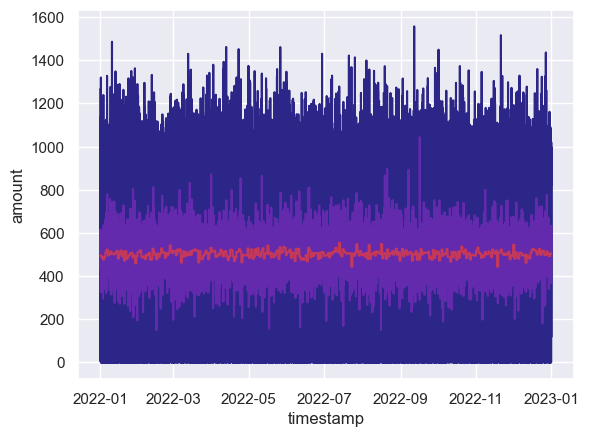

In [173]:
# Line plots ordered by amount of variable in variable

sb.lineplot(meta_ts, x = 'timestamp', y = 'amount'); 
sb.lineplot(meta_ts, x = 'timestamp', y = 'month_day_hour_avg'); 
sb.lineplot(meta_ts, x = 'timestamp', y = 'month_day_avg'); 

- No visual trend or seasonality throughout the year

### Are there any days whose avg amount transacted is roughly statistically significant?

In [196]:
# std of amount, month_day_avg, and month_day_hour_avg
meta_day_ts_mean = meta_ts['month_day_avg'].mean()
meta_day_ts_sd = meta_ts['month_day_avg'].std()

print('Upper Bound')
ci_upper_bound = meta_day_ts_mean + 1.96 * meta_day_ts_sd
ci_upper_bound
print('Lower Bound')
ci_lower_bound = meta_day_ts_mean - 1.96 * meta_day_ts_sd
ci_lower_bound

# reduce to columns of interest
test_sig_df = meta_ts.loc[:, ['month_day', 'month_day_avg']].drop_duplicates()

# days where the average transactions that day are outside of the 95% CI bounds
sig_diff_days = test_sig_df[(test_sig_df['month_day_avg'] < ci_lower_bound) | (test_sig_df['month_day_avg'] > ci_upper_bound)]

sig_diff_days


# lineplot for login number
# lineplot for session_duration

Upper Bound


535.530417577166

Lower Bound


469.61938784240795

,month_day,month_day_avg
6073,01-29,458.792111
12106,02-26,541.622401
13994,03-07,462.469714
16968,03-21,462.891709
23331,04-19,469.391838
24559,04-25,463.679619
29064,05-16,541.243746
31878,05-29,535.774514
35872,06-17,467.578342
41496,07-13,554.169196


- 19 days are outside of the confidence interval, but days appear random.
    - Day averages are still near mean
    - Nearly evenly distributed throughout the year
- Us gov study on consumer spending shows noticable variation from year to year:
    https://www.bls.gov/news.release/cesan.nr0.htm
  

In [224]:
# Assessing if there is a linear trend (macro economy has ~2% or more change per year)
from sklearn.linear_model import LinearRegression
import time

X = (meta['timestamp'].map(lambda x: time.mktime(x.timetuple())).to_frame())
y = meta['amount']

model = LinearRegression()
model.fit(X, y)

print('Slope (percent change over year time period)')
b1 = model.coef_
'{:.18f}'.format(b1[0])


LinearRegression()

Slope (percent change over year time period)


'0.000000040288110303'

- **Due to lack of variation for numerous key variables, difference from overall economic trends, and nearly 0 slope, I strongly believe this data is synthetic**
    - Will not deep dive on creating features as a result
    - Will continue to ML models regardless

### Next Section Includes ML Modeling